In [1]:
import importlib

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import os
import kad.visualization.visualization as visualization
import kad.kad_utils.kad_utils as kad_utils
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.model_selector.model_selector as model_selector
from kad.model import i_model, autoencoder_model, hmm_model, lstm_model
from kad.model import sarima_model
from sklearn.model_selection import train_test_split

kad_utils.customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython']


In [2]:
SARIMA_KEY: str = "SARIMA"
AUTOENCODER_KEY: str = "autoencoder"
HMM_KEY: str = "HMM"
LSTM_KEY: str = "LSTM"

ACC_KEY: str = "accuracy"
PREC_KEY: str = "precision"
RECALL_KEY: str = "recall"
AUROC_KEY: str = "auroc"

In [3]:

def downsampling_func(x: pd.DataFrame):
    """
    Values column is replaced with a mean, and labels are replaced by True if any of the labels
    in the original df was True
    :param x: part of dataframe to squash to one row
    :return: squashed pandas Series
    """
    values = x["value"].mean()

    labels = (x[kad_utils.GROUND_TRUTH_COLUMN]).any()

    return pd.Series([values, labels], index=["value", kad_utils.GROUND_TRUTH_COLUMN])

In [4]:
def perform_evaluation(evaluation_df: pd.DataFrame) -> dict:
    visualization.visualize(evaluation_df, metric_name="value")

    evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

    print("Accuracy: ", evaluator.get_accuracy())
    print("Avg precision: ", evaluator.get_average_precision())
    print("Recall: ", evaluator.get_recall_score())
    print("AU ROC: ", evaluator.get_auroc())

    return {ACC_KEY: evaluator.get_accuracy(),
            PREC_KEY: evaluator.get_average_precision(),
            RECALL_KEY: evaluator.get_recall_score(),
            AUROC_KEY: evaluator.get_auroc()}


In [5]:
def evaluate_sarima(p_preprocessed_df: pd.DataFrame) -> dict:
    values_df = p_preprocessed_df[["value"]]
    tsa = model_selector.ModelSelector(values_df)
    dominant_freq = tsa.calculate_dominant_frequency()

    model: i_model.IModel = sarima_model.SarimaModel(order=(0, 0, 0), seasonal_order=(1, 0, 1, dominant_freq))

    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 18
    for i in range(0, len(test_df), samples_to_predict):
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    results_df = results_df.loc[test_df.index & results_df.index]

    return perform_evaluation(results_df)

In [6]:
def evaluate_autoencoder(p_preprocessed_df: pd.DataFrame) -> dict:
    model: i_model.IModel = autoencoder_model.AutoEncoderModel(time_steps=12)

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 60
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    results_df = results_df.loc[test_df.index & results_df.index]

    return perform_evaluation(results_df)

In [7]:
def evaluate_hmm(p_preprocessed_df: pd.DataFrame) -> dict:
    model: i_model.IModel = hmm_model.HmmModel()

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 5
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    results_df = results_df.loc[test_df.index & results_df.index]

    return perform_evaluation(results_df)

In [8]:
def evaluate_lstm(p_preprocessed_df: pd.DataFrame) -> dict:
    model: i_model.IModel = lstm_model.LstmModel(time_steps=12)

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 25
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    results_df = results_df.loc[test_df.index & results_df.index]

    return perform_evaluation(results_df)

after reading csv
art_daily_nojump.csv
art_daily_flatmiddle.csv
art_daily_jumpsup.csv
art_daily_jumpsdown.csv
after reading csv
after reading csv
after reading csv
sarima
sarima
sarima
sarima


<ipython-input-5-da49717d10d6>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]
<ipython-input-5-da49717d10d6>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]
<ipython-input-5-da49717d10d6>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.64
Avg precision:  0.26
Recall:  0.26
AU ROC:  0.63


<ipython-input-5-da49717d10d6>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.82
Avg precision:  0.36
Accuracy:  Recall: 0.82 
0.26
Avg precision: AU ROC:   0.350.65

Recall:  0.79
AU ROC:  0.65
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 12, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 12, 1)             129

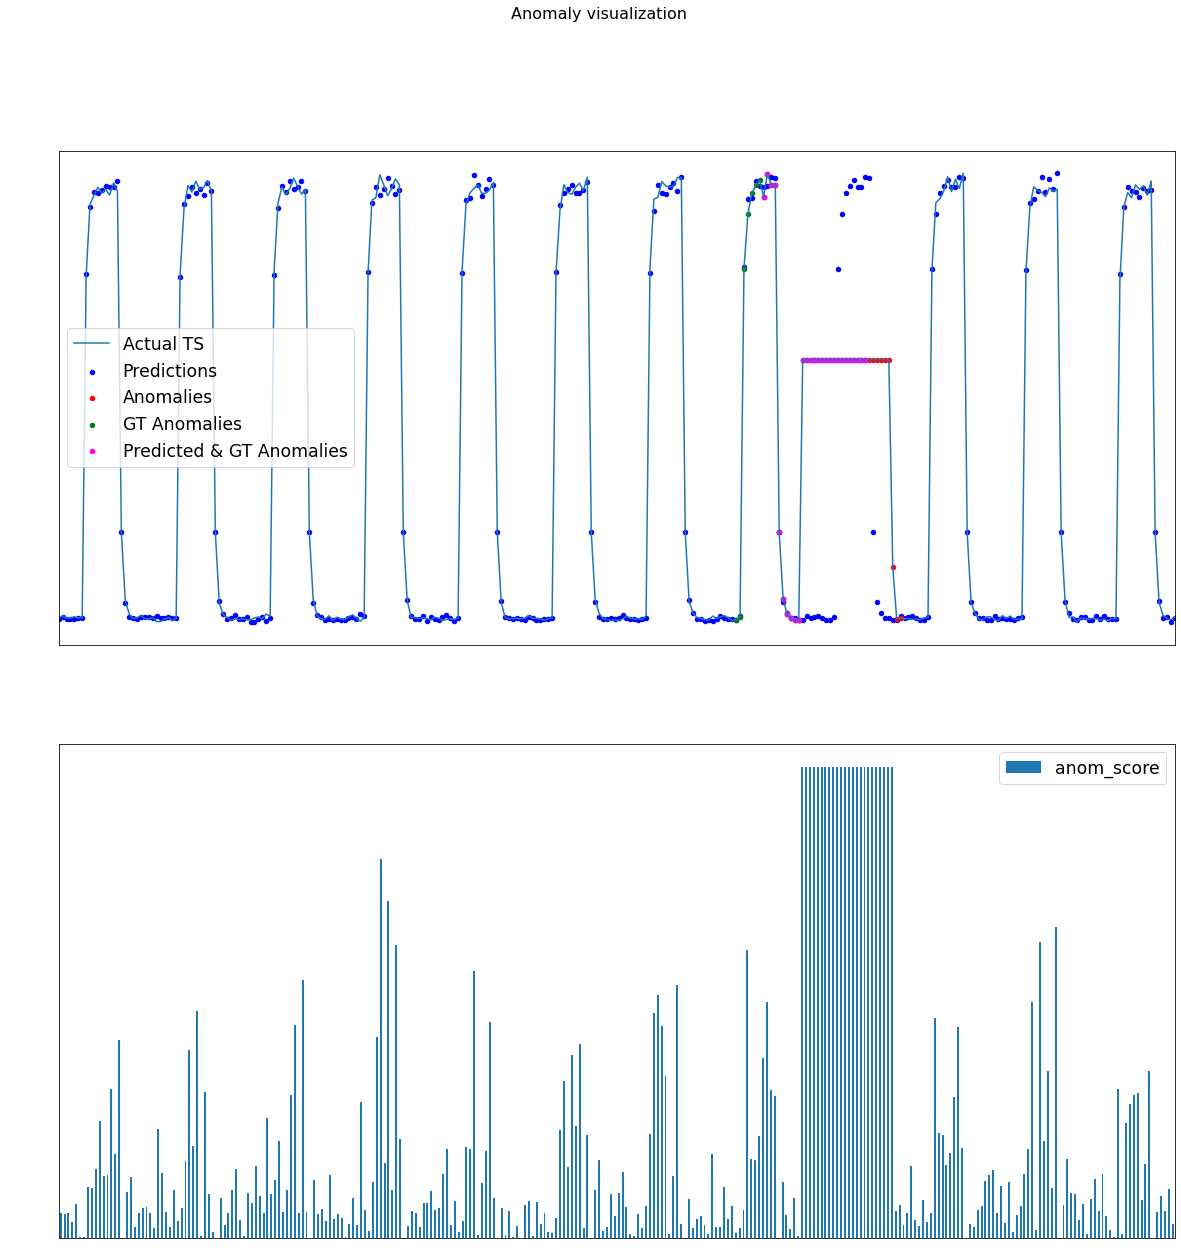

31/31 [==============================] - ETA: 0s - loss: 0.0011 - ETA: 1s - loss: 0.0066 - ETA: 1s - loss: 0.006431/31 [==============================] - ETA: 0s - loss: 0.0011 - ETA: 0s - loss: 0.0036 - ETA: 0s - loss: 0.0011 - ETA: 1s - loss: 0.0061 8/31 [======>.......................]28/31 [==========================>...] - ETA: 1s - loss: 0.0060 - ETA: 0s - loss: 0.0010 - 1s 46ms/step - loss: 0.0036 - val_loss: 0.0072


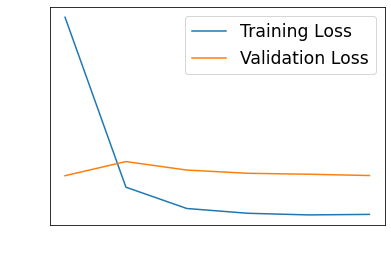

Epoch 9/50
7/31 [=====>........................] - ETA: 0s - loss: 0.0010 - ETA: 1s - loss: 0.003631/31 [==============================]11/31 [=========>....................] - ETA: 0s - loss: 0.0010 - ETA: 1s - loss: 0.0056 - ETA: 1s - loss: 0.0037 - ETA: 0s - loss: 0.0055 5/31 [===>..........................]13/31 [===========>..................] - ETA: 0s - loss: 0.0054 - ETA: 0s - loss: 0.0040

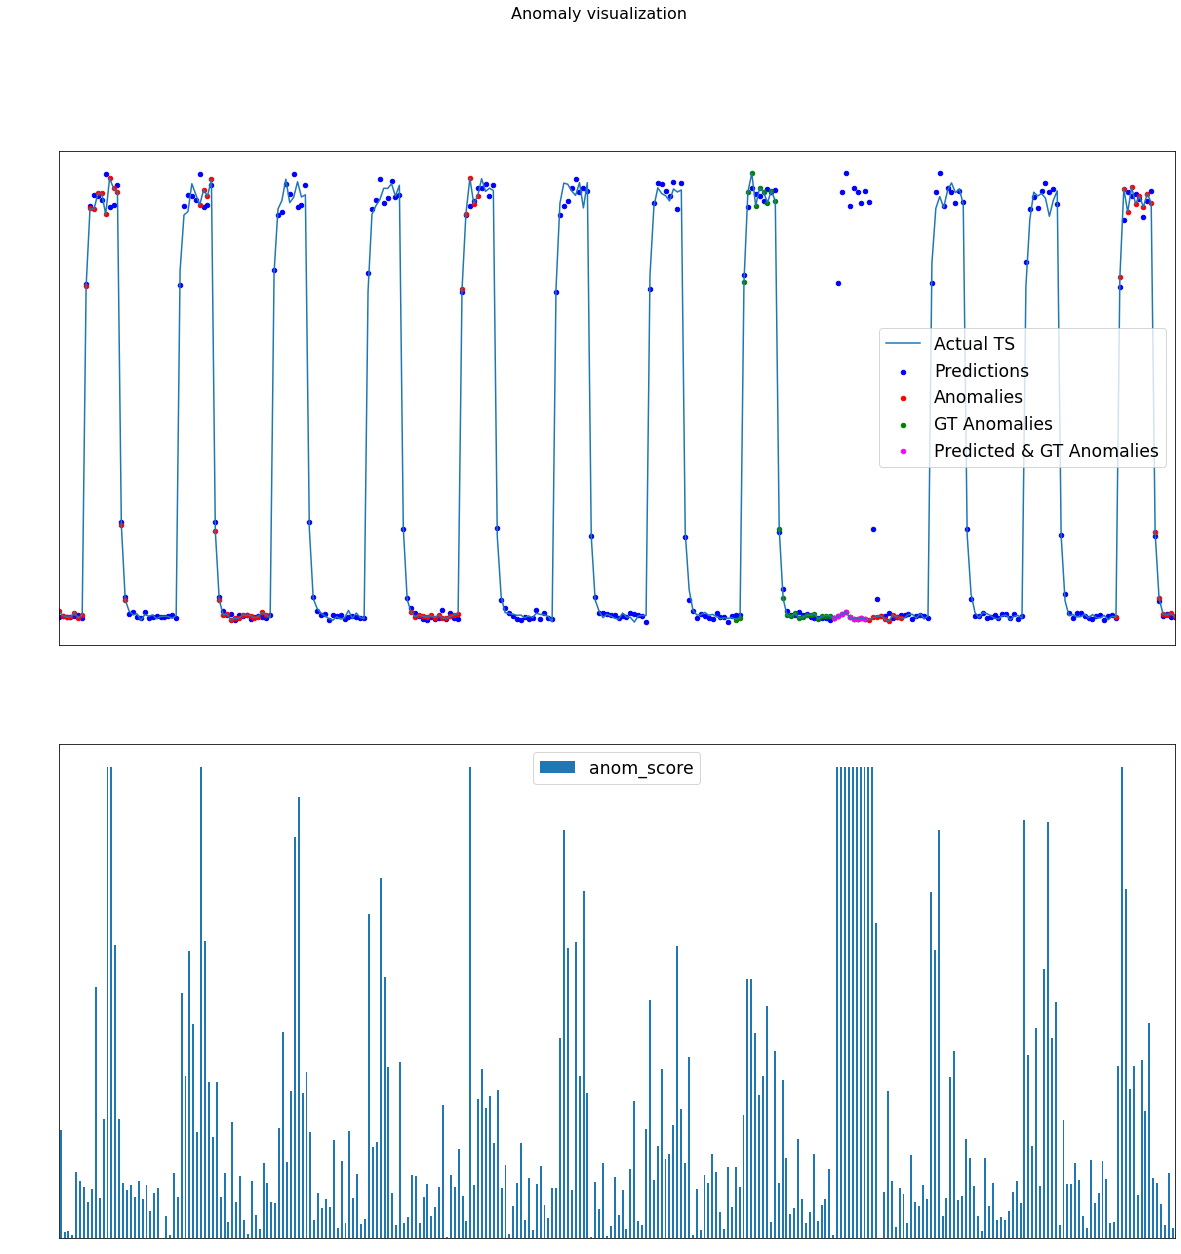

- ETA: 0s - loss: 8.4984e-04e-04 - ETA: 0s - loss: 0.0042 - ETA: 0s - loss: 8.3037e-04 - ETA: 0s - loss: 0.004210/31 [========>.....................]19/31 [=================>............] - ETA: 0s - loss: 0.004220/31 [==================>...........]11/31 [=========>....................] - ETA: 0s - loss: 0.0041 - ETA: 0s - loss: 8.7138e-04

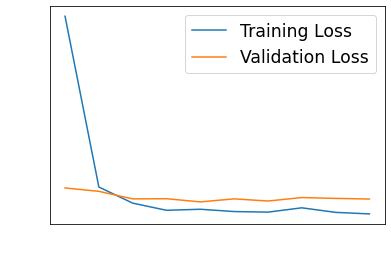

31/31 [==============================]22/31 [====================>.........]13/31 [===========>..................] - ETA: 0s - loss: 8.9153e-0415/31 [=============>................]24/31 [======================>.......] - ETA: 0s - loss: 8.9954e-04 - ETA: 0s - loss: 0.004017/31 [===============>..............] - ETA: 0s - loss: 9.0425e-04 - ETA: 0s - loss: 0.0040 - ETA: 0s - loss: 0.0040 - ETA: 0s - loss: 9.1138e-04 - ETA: 0s - loss: 0.0040 - ETA: 0s - loss: 9.1411e-04

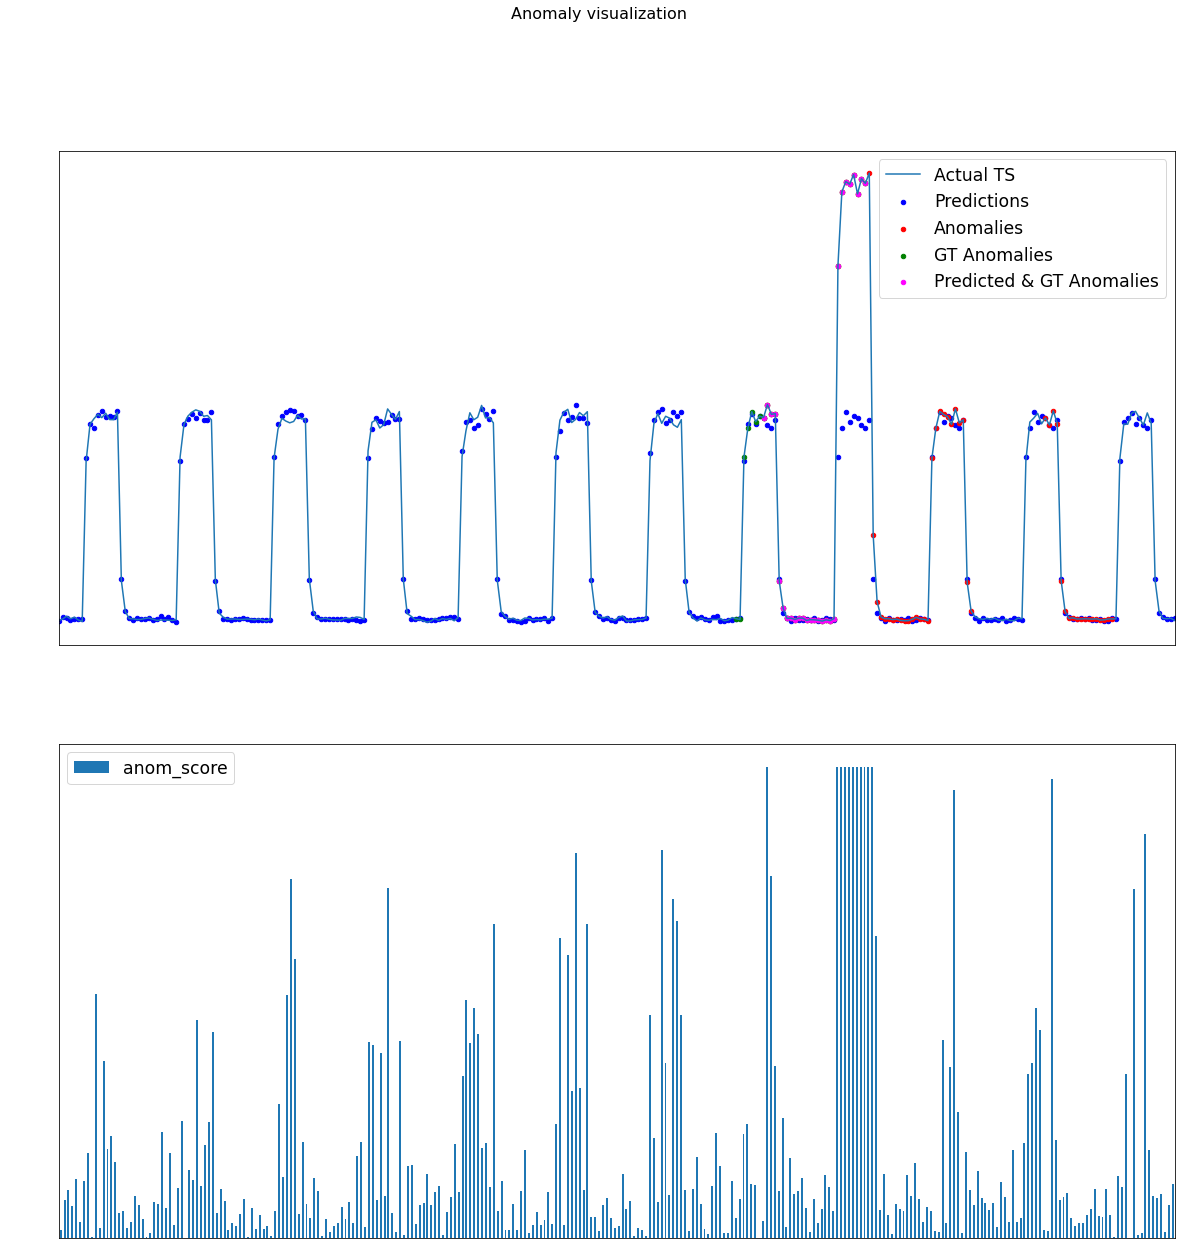

18/31 [================>.............] - ETA: 1s - loss: 0.0038 - ETA: 1s - loss: 0.0038 - ETA: 1s - loss: 0.0038 - ETA: 0s - loss: 0.0037

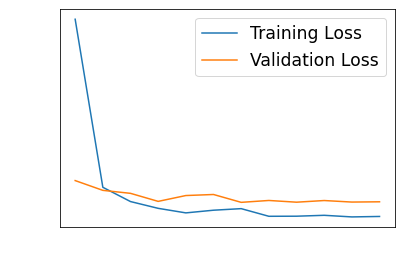

<ipython-input-6-07c0ddccccd0>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


31/31 [==============================] - 2s 73ms/step - loss: 0.0036 - val_loss: 0.0073


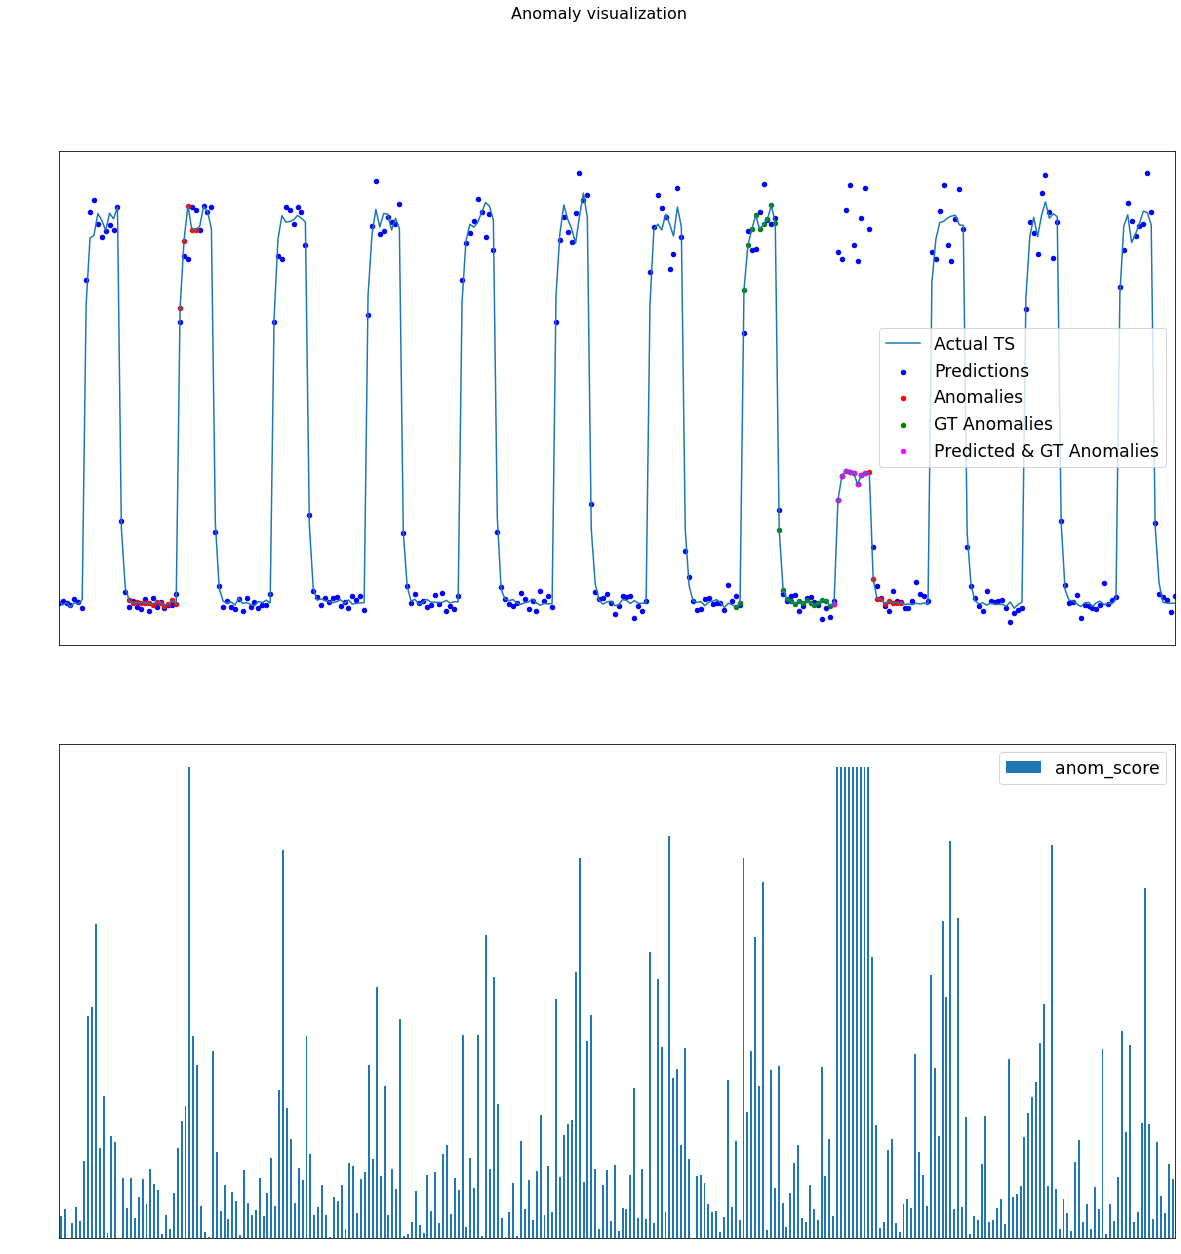

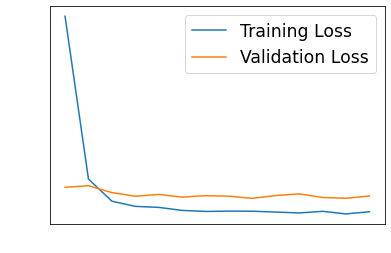

<ipython-input-6-07c0ddccccd0>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]
<ipython-input-6-07c0ddccccd0>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]
<ipython-input-6-07c0ddccccd0>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.88
Avg precision:  0.22
Recall:  0.0
AU ROC:  0.73


<ipython-input-7-c23938d8d94b>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.85
Avg precision:  0.2
Recall:  0.56
AU ROC:  0.63
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
Accuracy:  0.88
Avg precision:  0.11
Recall:  0.0
AU ROC:  0.43


<ipython-input-7-c23938d8d94b>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.89
Avg precision:  0.3Accuracy: 
 Recall: 0.82 0.19

AU ROC:  Avg precision: 0.63 0.12

Recall:  0.06
AU ROC:  0.49
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________1/1 [==============================] - ETA: 0s - loss: 0.5470
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


<ipython-input-7-c23938d8d94b>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


1/1 [==============================] - 7s 7s/step - loss: 0.5470 - val_loss: 0.1201
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.5222 - 0s 127ms/step - loss: 0.5222 - val_loss: 0.1186
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.5048 - 0s 165ms/step - loss: 0.5048 - val_loss: 0.1172
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.4834 - 0s 182ms/step - loss: 0.4834 - val_loss: 0.1158
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 0.4761 - 0s 183ms/step - loss: 0.4761 - val_loss: 0.1145
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 0.4506 - 0s 157ms/step - los

<ipython-input-7-c23938d8d94b>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


1/1 [==============================] - ETA: 0s - loss: 0.4779Accuracy:  0.84
Avg precision:  0.15
Recall:  0.29
AU ROC:  0.56
1/1 [==============================] - 6s 6s/step - loss: 0.4779 - val_loss: 0.1173
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.4637 - 0s 172ms/step - loss: 0.4637 - val_loss: 0.1159
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.4501 - 0s 187ms/step - loss: 0.4501 - val_loss: 0.1145
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.4344 - 0s 156ms/step - loss: 0.4344 - val_loss: 0.1131
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 0.4265Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape            

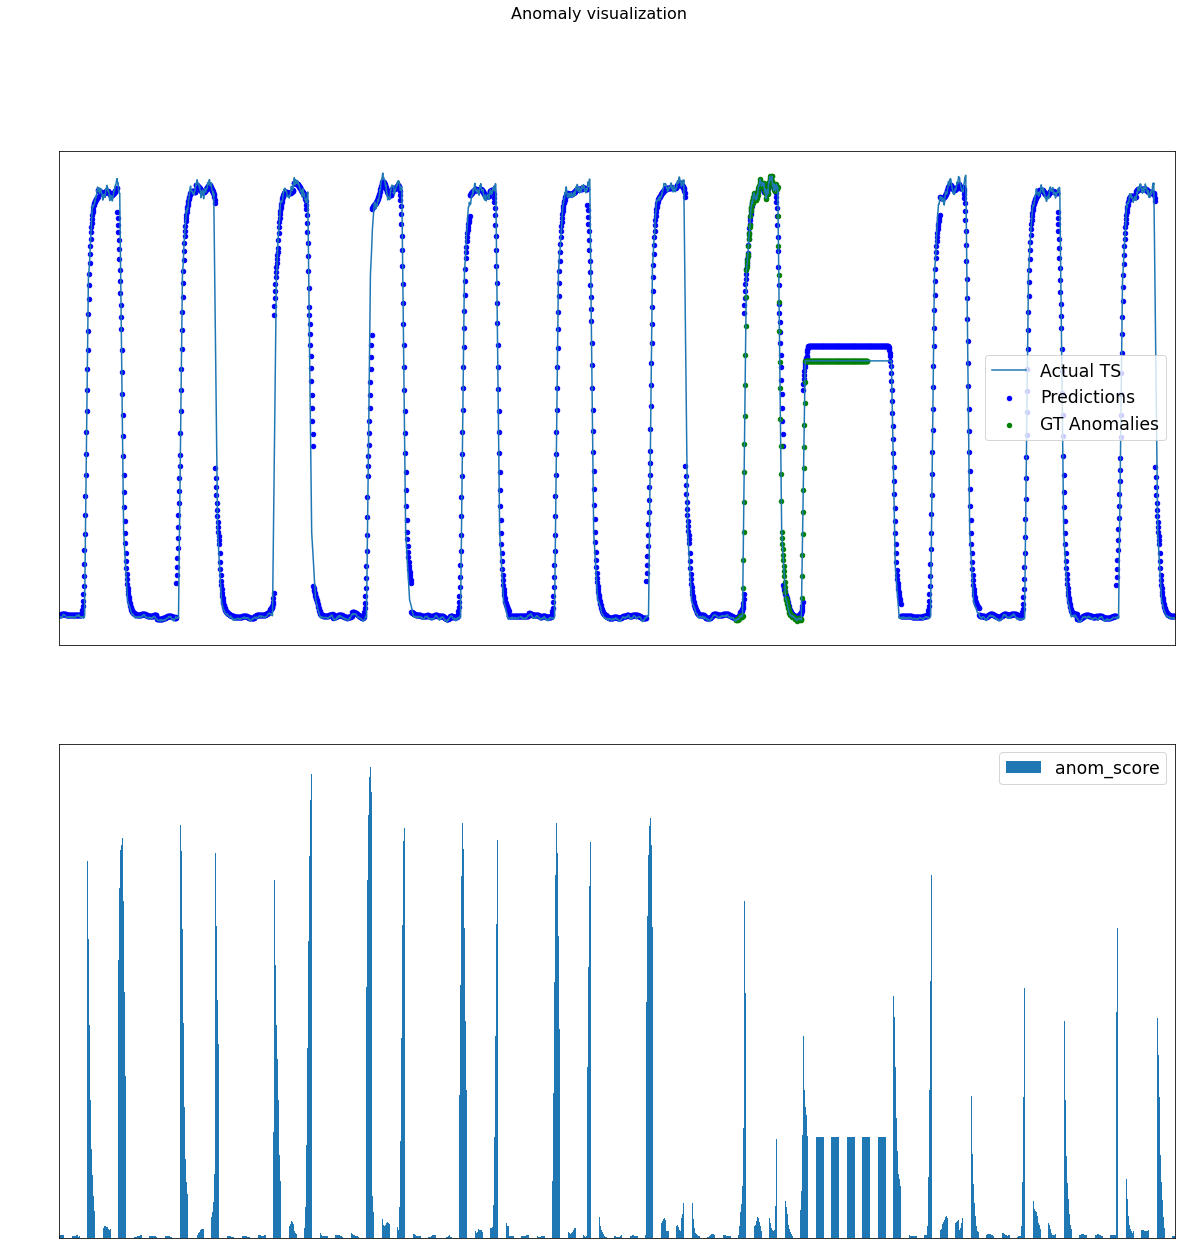

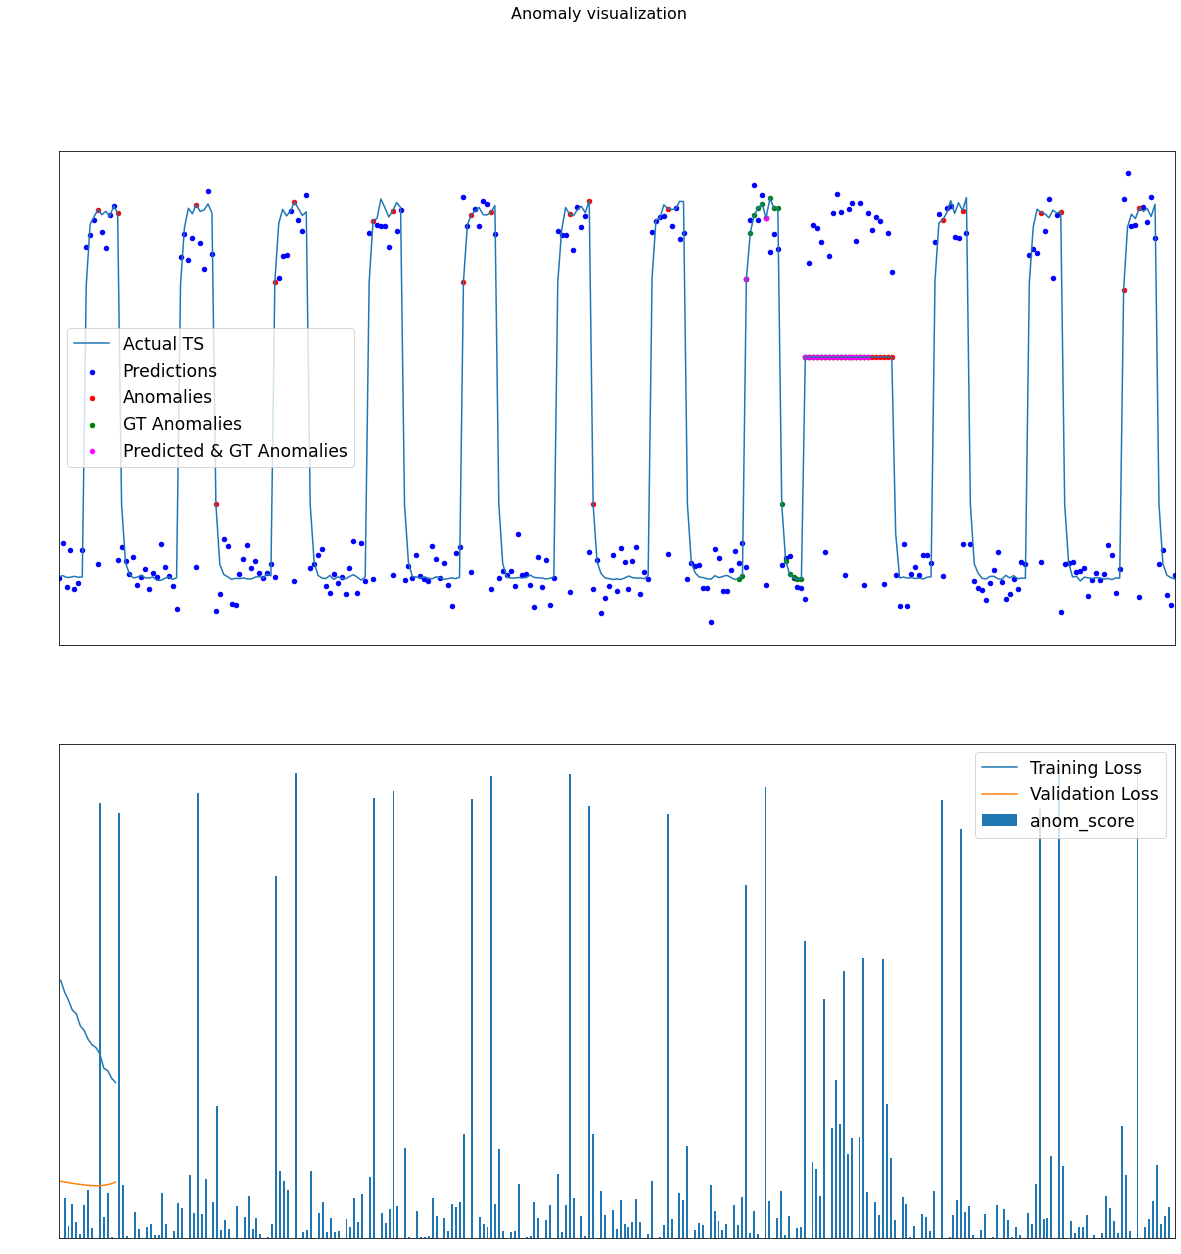

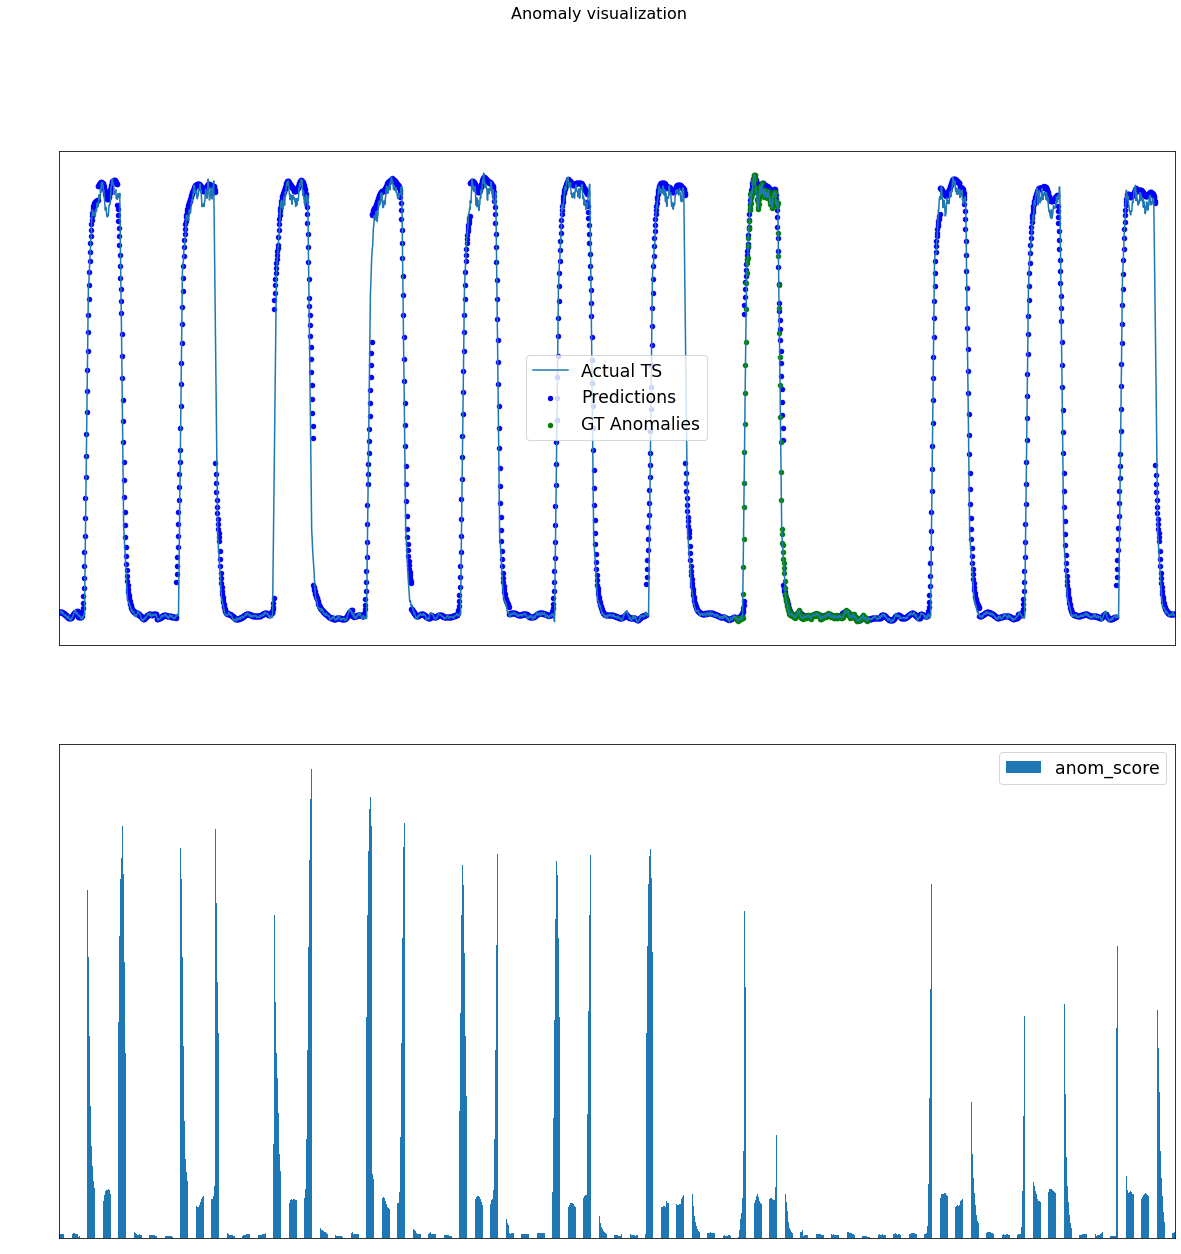

<ipython-input-8-f81d2d4f3101>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.65
Avg precision:  0.14
Recall:  0.21
AU ROC:  0.59


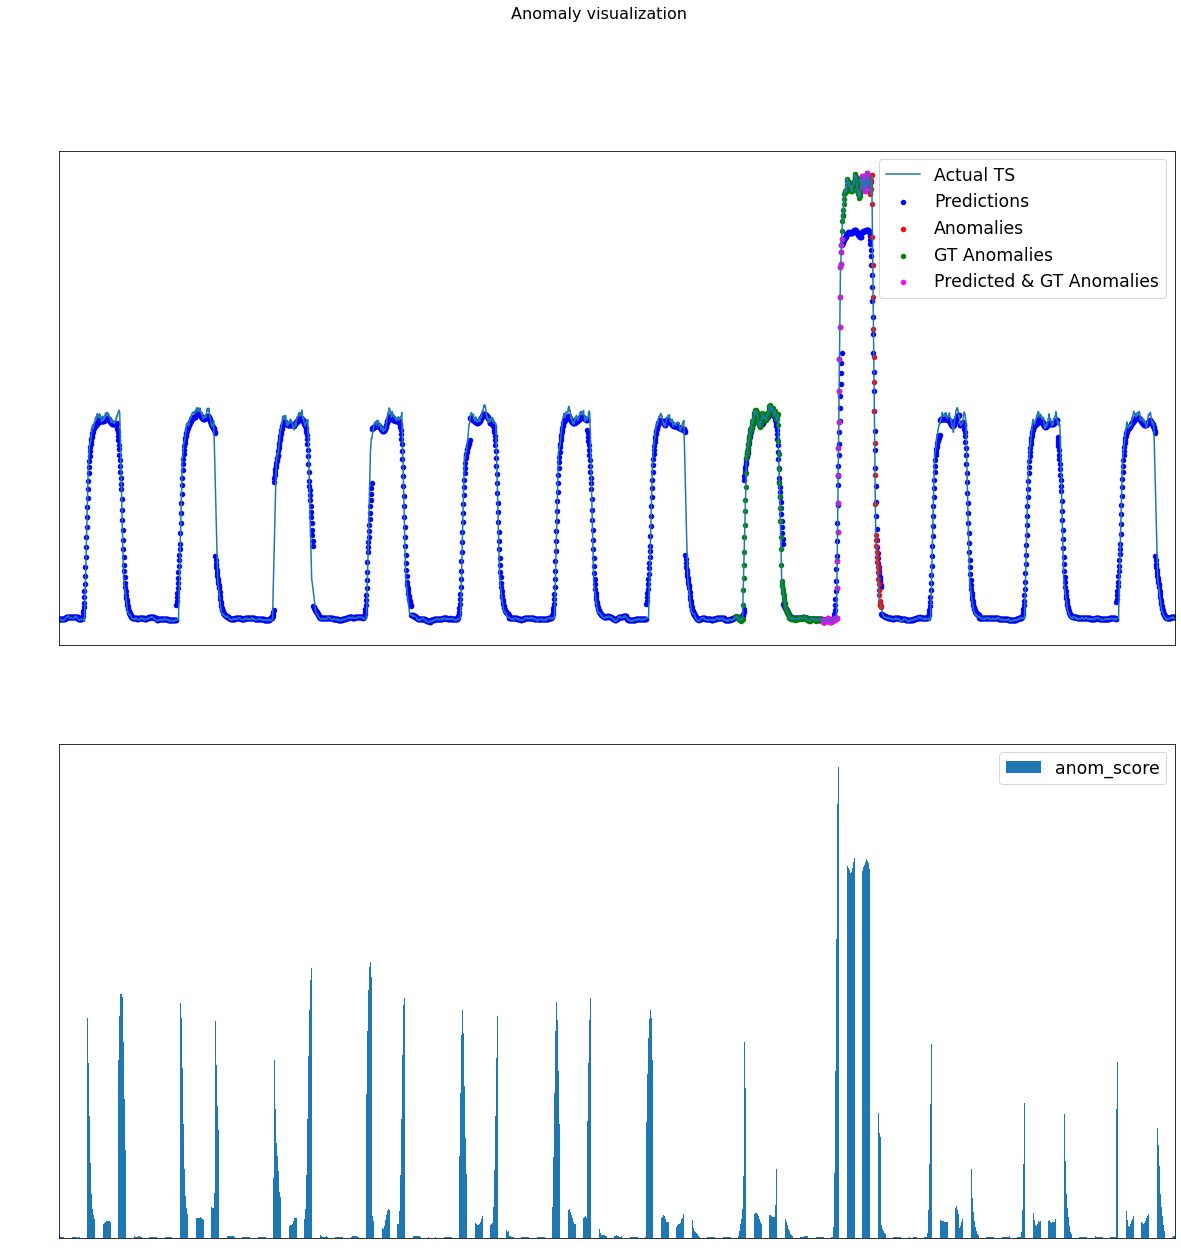

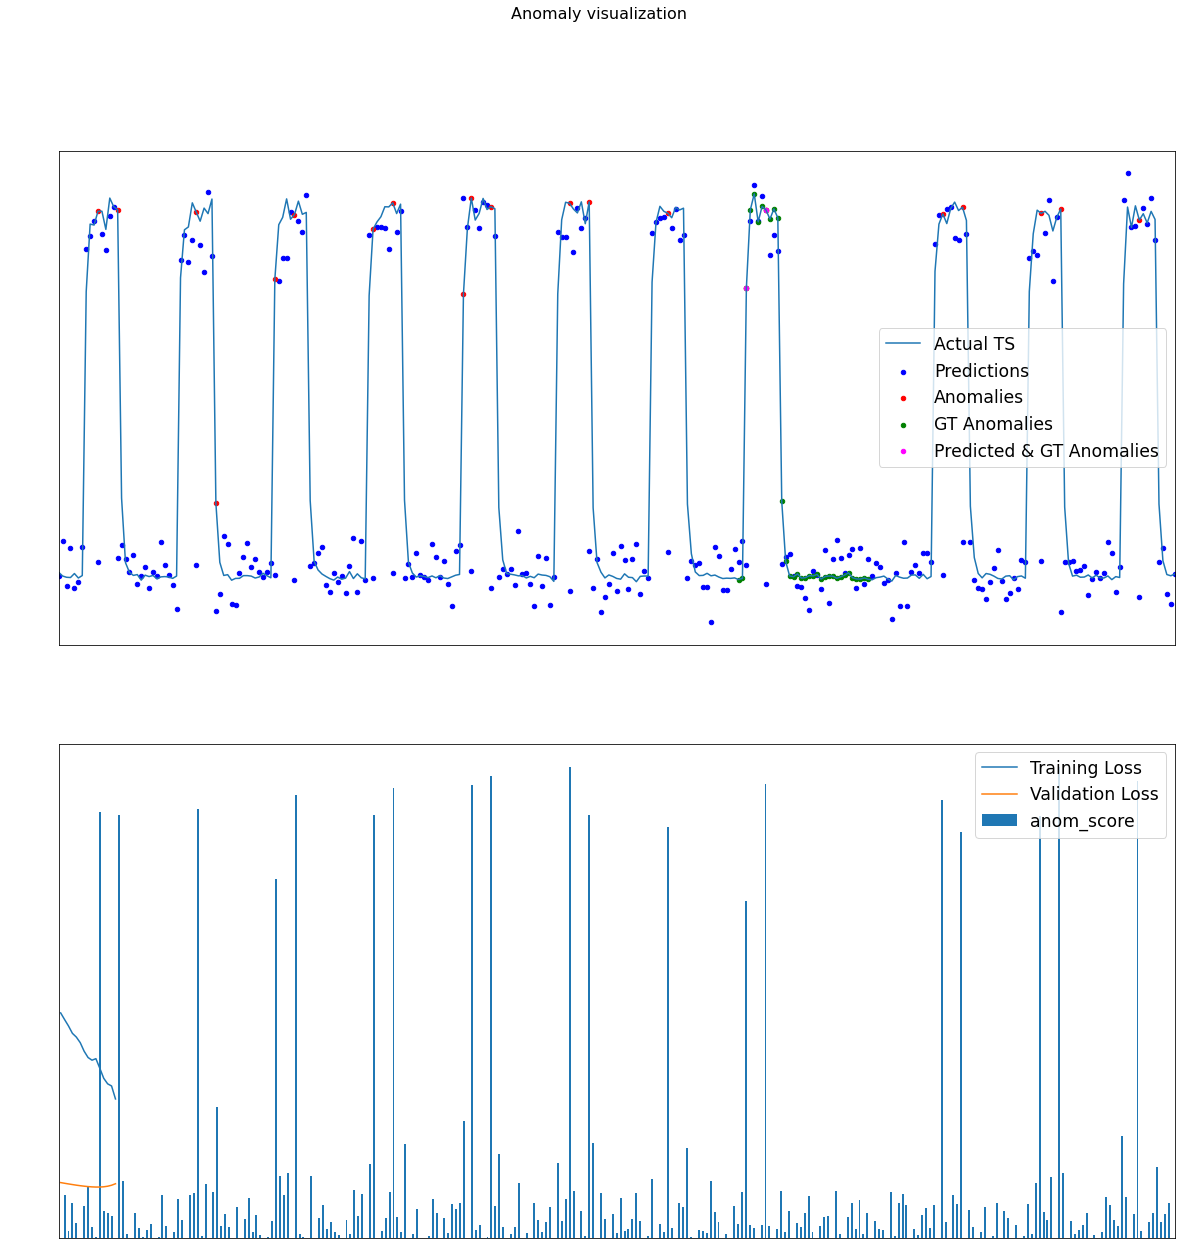

<ipython-input-8-f81d2d4f3101>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


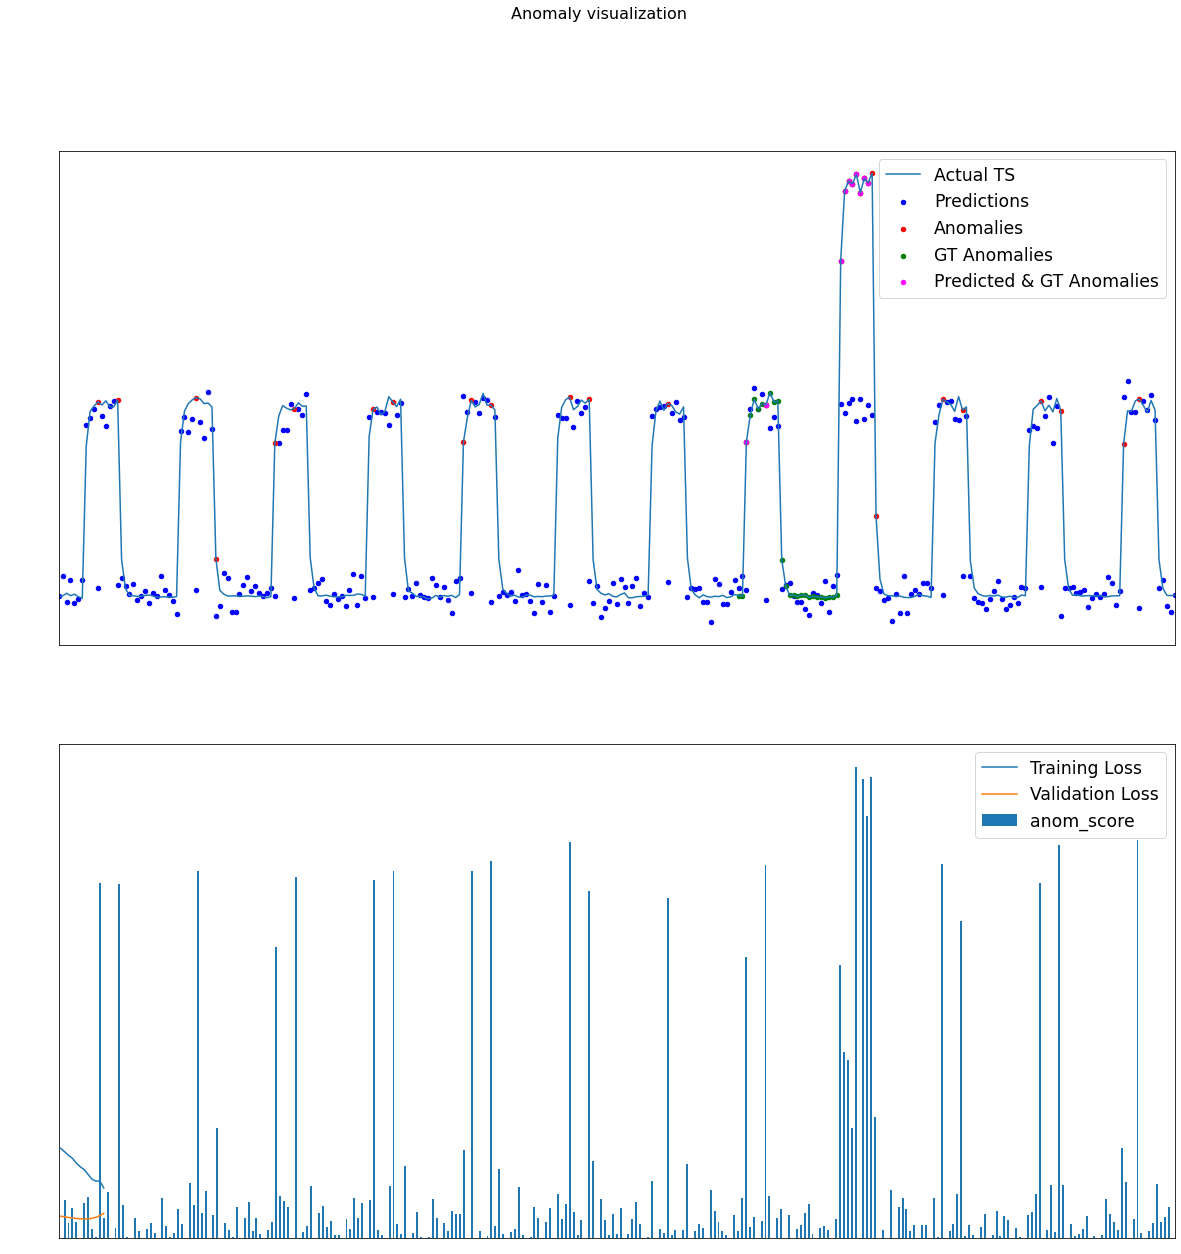

Accuracy:  0.65
Avg precision:  0.08
Recall:  0.21
AU ROC:  0.24


<ipython-input-8-f81d2d4f3101>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


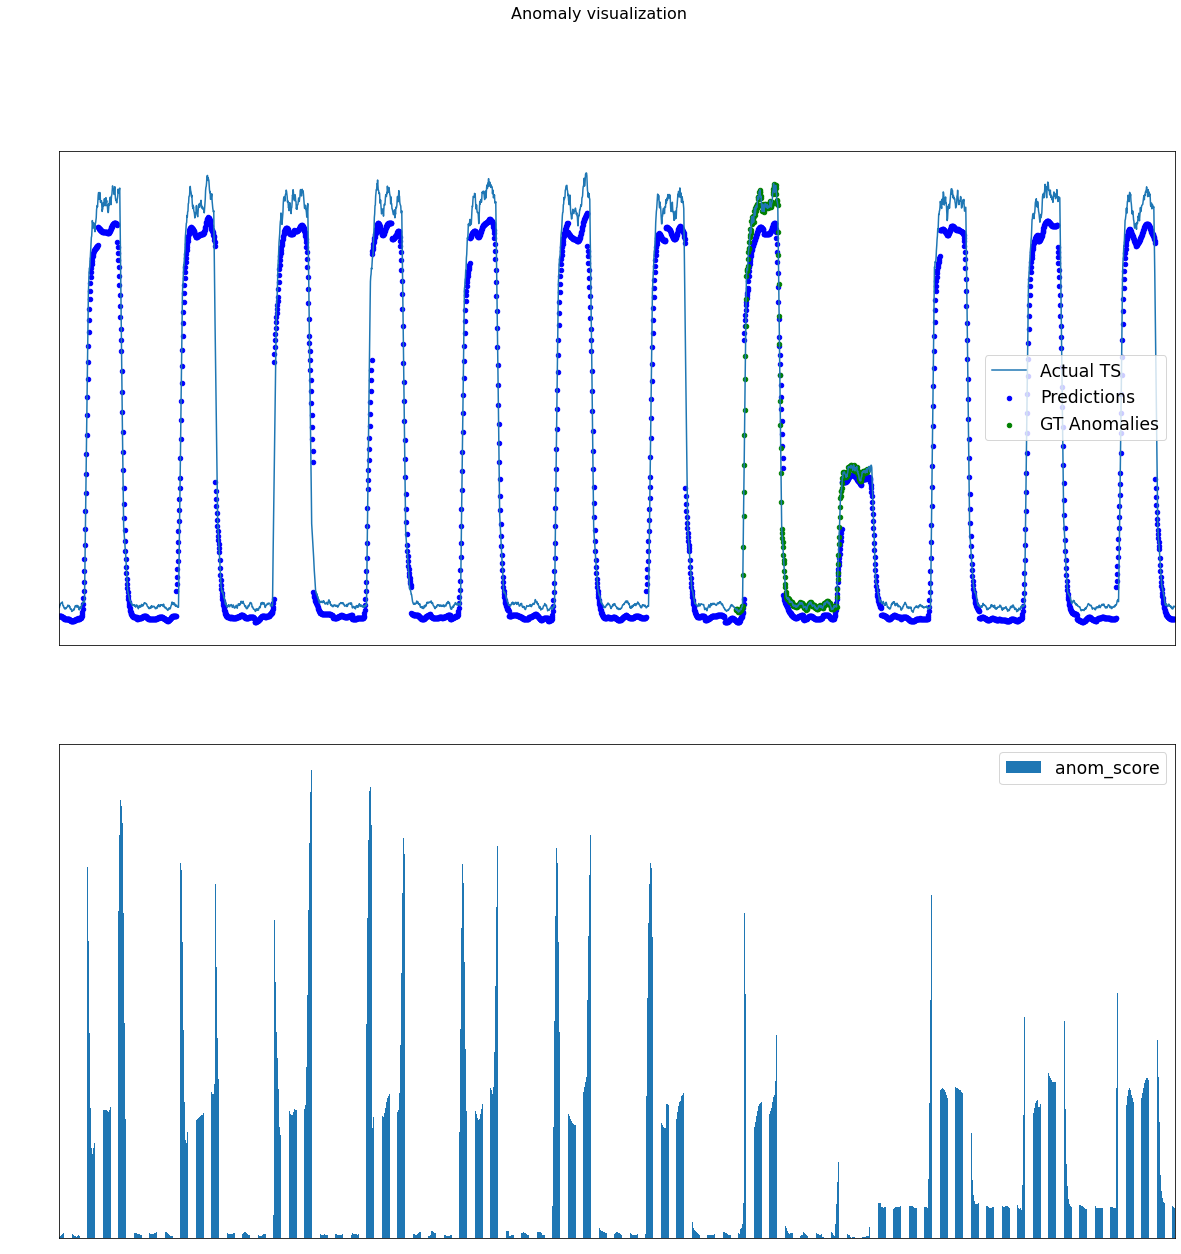

Accuracy:  0.97
Avg precision:  0.23
Recall:  0.74
AU ROC:  0.63


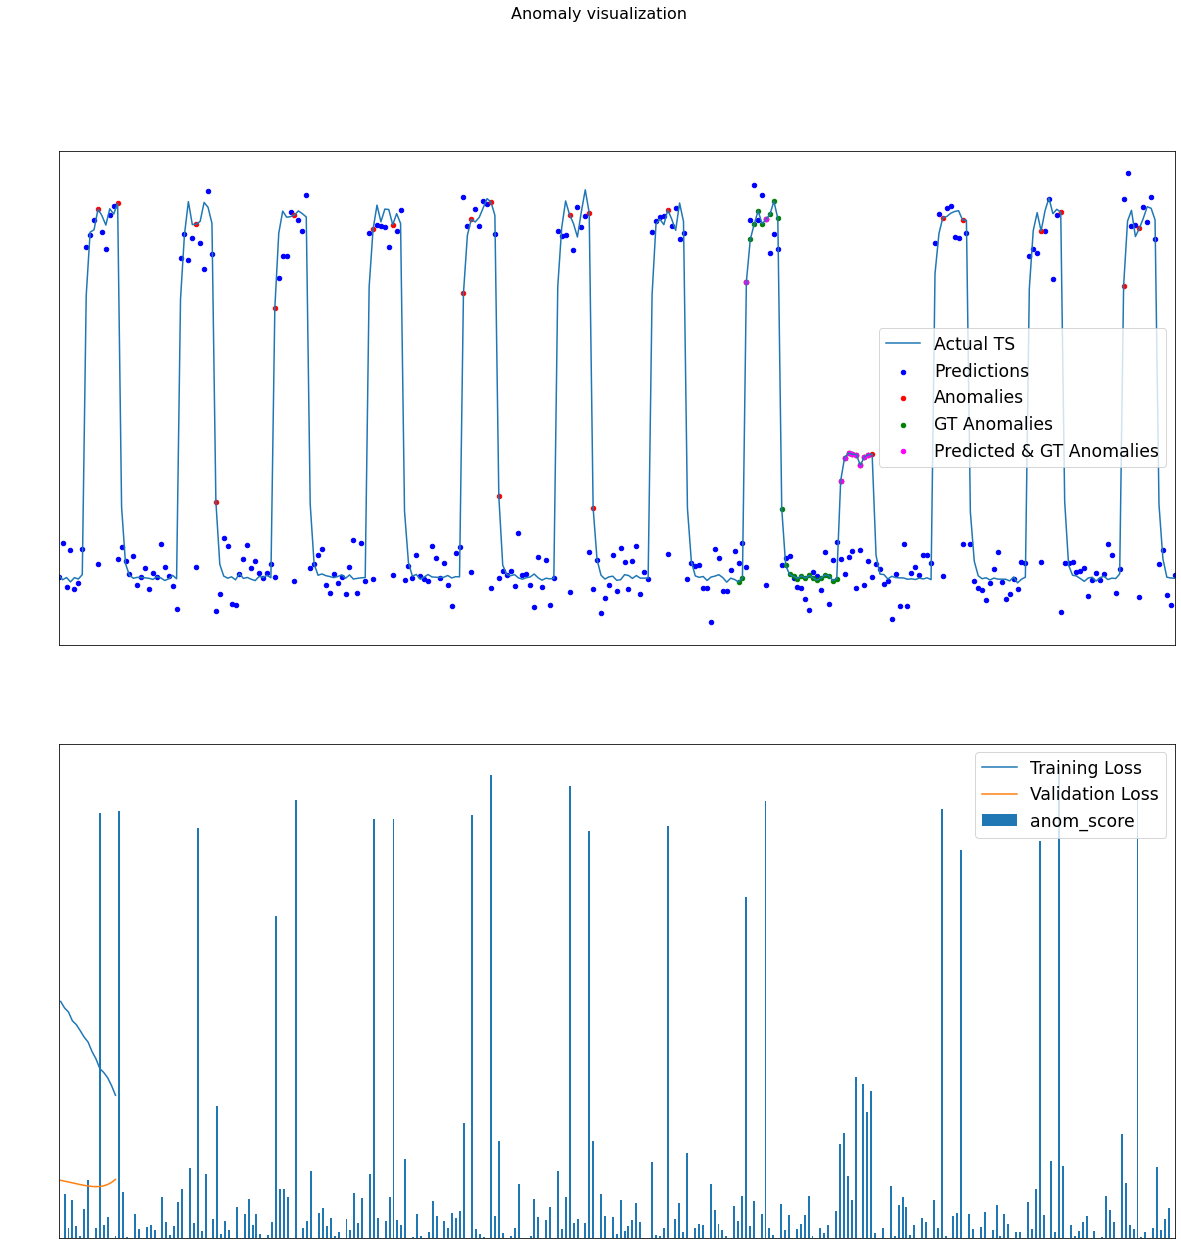

<ipython-input-8-f81d2d4f3101>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  results_df = results_df.loc[test_df.index & results_df.index]


Accuracy:  0.79
Avg precision:  0.1
Recall:  0.0
AU ROC:  0.43


In [9]:
from typing import Tuple
import concurrent

eval_dict: dict = {}

X_LABEL = "timestamp"
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"

with open("data/archive/combined_windows.json") as f:
    ground_true_anomalies = json.load(f)

executor = concurrent.futures.ProcessPoolExecutor()


def task_executor(filename: str, original_df: pd.DataFrame, ground_true_anomalies: dict):
    file_eval_dict = {}

    true_anomalies_ranges = ground_true_anomalies["/".join(file_path.split("/")[-2:])]
    ground_true_anomalies_df = pd.DataFrame()
    for anom_range in true_anomalies_ranges:
        ground_true_anomalies_df = ground_true_anomalies_df.append(
            original_df.loc[anom_range[0]:anom_range[1]])
    original_df[kad_utils.GROUND_TRUTH_COLUMN] = [idx in ground_true_anomalies_df.index for idx in
                                                  original_df.index.tolist()]

    # SARIMA
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    sarima_results = evaluate_sarima(preprocessed_df)
    file_eval_dict[SARIMA_KEY] = sarima_results

    # AUTOENCODER
    preprocessed_df = original_df.copy()
    preprocessed_df["value"] = preprocessed_df["value"].rolling("h").sum()
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    autoencoder_results = evaluate_autoencoder(preprocessed_df)
    file_eval_dict[AUTOENCODER_KEY] = autoencoder_results

    # HMM
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    hmm_results = evaluate_hmm(preprocessed_df)
    file_eval_dict[HMM_KEY] = hmm_results

    # LSTM
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    lstm_results = evaluate_lstm(preprocessed_df)
    file_eval_dict[LSTM_KEY] = lstm_results

    return filename, file_eval_dict


files_to_eval = ["art_daily_flatmiddle.csv",
                 "art_daily_jumpsdown.csv",
                 "art_daily_nojump.csv",
                 "art_daily_jumpsup.csv"]

futures_table = list()

for (dirpath, dirnames, filenames) in os.walk(data_dir):
    for filename in filenames:
        if filename in files_to_eval:
            file_path = os.path.join(dirpath, filename)
            original_df = pd.read_csv(file_path, parse_dates=True, index_col="timestamp")
            print("after reading csv")
            futures_table.append(
                executor.submit(task_executor, filename, original_df, ground_true_anomalies))

for future in futures_table:
    result: Tuple[str, dict] = future.result()
    eval_dict[result[0]] = result[1]

In [10]:
eval_json = "eval.json"

with open(eval_json, "w") as fp:
    json.dump(eval_dict, fp)
